# Import libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models

import matplotlib.pyplot as plt
%matplotlib inline

seed = int(datetime.now().timestamp())
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

strategy = tf.distribute.MirroredStrategy()
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


# Parameters setting

In [2]:
from math import log

# Set to True if you want to work with the dataset cleaned
dataset_cleaning = False

use_cleaned_dataset = True

epochs = 200
batch_size = 64
l2_lambda = 0.001
learning_rate = 1e-3
val_split = 0.2
patience = 30
dropout_rate = 0.5
balance_mode = "weights"
max_weight = 5.0
augmentation = True

# Bottle Filter Size
bfs = 64

# True if excluded classes from oversample must be set to 0 (the mask)
overs_ignore_classes = False

# True if apply augmentation to oversampled images
overs_augmentation = True

advanced_split_dataset = True
threshold_percentage = 75.0

# It may change during class balance
loss = tfk.losses.SparseCategoricalCrossentropy(from_logits=False)

balance_modes = [
    "weights",
    "oversampling",
    "mixed",
    ""
]

assert epochs > 0
assert val_split >= 0 and val_split <= 1
assert batch_size > 4 and log(batch_size, 2) == int(log(batch_size, 2))
assert learning_rate > 0
assert patience > 0
patience = min(epochs, patience)
assert dropout_rate >= 0
assert not (dataset_cleaning and use_cleaned_dataset)
assert bfs > 16 and log(bfs, 2) == int(log(bfs, 2))
assert balance_mode in balance_modes

print(f"Epochs: {epochs} \nPatience: {patience}")

Epochs: 200 
Patience: 30


# Dataset cleaning

In [3]:
from scipy.stats import chi2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Ellipse

def clean_dataset() :
    dataset_dir = "/kaggle/input/mars-dataset/mars_for_students.npz"
    data = np.load(dataset_dir)
    
    training_set = data["training_set"]
    
    X = training_set[:, 0]
    y = training_set[:, 1]
    X_test = data["test_set"]
    
    # Creation of the dictionary 
    labels = {0:'Background', 1:'Soil', 2:'Bedrock', 3:'Sand', 4:'Big Rock'}

    alien_indices = [62,79,125,139,142,147,152,156,170,210,217,266,289,299,313,339,348,365,412,417,426,450,461,536,552,669,675,741,744,747,799,802,808,820,821,849,863,890,909,942,971,1005,1057,1079,1082,1092,1095,1106,1119,1125,1177,1194,1224,1247,1248,1258,1261,1262,1306,1324,1365,1370,1443,1449,1508,1509,1519,1551,1584,1588,1628,1637,1693,1736,1767,1768,1782,1813,1816,1834,1889,1925,1942,1975,1979,2000,2002,2086,2096,2110,2111,2151,2161,2222,2235,2239,2242,2301,2307,2350,2361,2365,2372,2414,2453,2522,2535,2561,2609,2614]    
    # Create a mask to remove alien indices (outliers)
    mask = np.ones(len(X), dtype=bool)
    mask[alien_indices] = False
    
    # Apply mask to X and y
    X = X[mask]
    y = y[mask, :, :]  # Ensure y has the same length as X

    # Finding the unique images to avoid duplicates
    _, unique_indices = np.unique(X.reshape(len(X), -1), axis=0, return_index=True)
    
    # Select only those images
    X_clean = X[unique_indices]
    y_clean = y[unique_indices, :, :]

    # Appiattisci le immagini
    X_flat = X_clean.reshape(X_clean.shape[0], -1)  # X_clean ha shape (n_samples, 64, 128)
    
    # Opzionalmente riduci la dimensionalità con PCA
    n_components = 2  # Seleziona un numero di componenti appropriato
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_flat)
    
    # Calcola la media e la matrice di covarianza nei dati ridotti
    mean = np.mean(X_reduced, axis=0)
    cov_matrix = np.cov(X_reduced, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Funzione per calcolare la distanza di Mahalanobis
    def mahalanobis_distance(x, mean, inv_cov_matrix):
        return np.sqrt((x - mean).T @ inv_cov_matrix @ (x - mean))
    
    # Calcola le distanze di Mahalanobis per tutti i dati ridotti
    distances = np.array([mahalanobis_distance(x, mean, inv_cov_matrix) for x in X_reduced])
    
    # Soglia basata su distribuzione chi-quadro
    alpha = 0.99  # livello di confidenza
    threshold = np.sqrt(chi2.ppf(alpha, df=n_components))  # df = numero di componenti PCA
    
    # Identifica gli outliers
    outliers = distances > threshold
    
    # Crea il grafico
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Funzione per sovrapporre immagini sui punti
    def imscatter(x, y, image, ax=None, zoom=0.1):
        if ax is None:
            ax = plt.gca()
        imagebox = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
    
    # Disegna i punti PCA con le immagini
    for i, (x, y) in enumerate(X_reduced):
        img = X_clean[i]  # Usa l'immagine originale
        imscatter(x, y, img, ax=ax, zoom=0.2)
    
    # Disegna l'ellisse della covarianza
    lambda_, v = np.linalg.eig(cov_matrix)
    lambda_ = np.sqrt(lambda_)
    ellipse = Ellipse(xy=mean,
                      width=lambda_[0] * 2 * np.sqrt(chi2.ppf(alpha, 2)),
                      height=lambda_[1] * 2 * np.sqrt(chi2.ppf(alpha, 2)),
                      edgecolor='green',
                      facecolor='none',
                      linestyle='--',
                      linewidth=2,
                      label="Covariance Ellipse")
    ax.add_patch(ellipse)
    
    # Evidenzia gli outliers
    for i, (x, y) in enumerate(X_reduced[outliers]):
        ax.scatter(x, y, color='red', label="Outlier" if i == 0 else "", s=100, edgecolors='k')
    
    # Etichette e legenda
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_title("PCA Outlier Detection with Images (Mahalanobis Distance)")
    ax.legend()
    
    plt.savefig("/kaggle/working/outliers.png")
    plt.show()
    
    # Rimuovi gli outliers
    X_clean = X_clean[~outliers]
    y_clean = y_clean[~outliers, :, :]

    training_set = np.zeros((X_clean.shape[0], 2, X.shape[1], X.shape[2]))
    training_set[:, 0, :, :] = X_clean
    training_set[:, 1, :, :] = y_clean
    
    # Salva il sottoinsieme in un nuovo file .npz
    subset_path = "/kaggle/working/correct_dataset.npz"
    np.savez(subset_path, training_set=training_set, test_set=X_test)

if dataset_cleaning :
    clean_dataset()

# Load data

In [4]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

dataset_dir = "/kaggle/working/correct_dataset.npz" if dataset_cleaning else "/kaggle/input/mars-dataset/mars_for_students.npz"

if use_cleaned_dataset :
    dataset_dir = "/kaggle/input/correct-mars/correct_dataset.npz"

data = np.load(dataset_dir)

training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

num_classes = len(np.unique(y_train))


# Creation of the dictionary 
labels = {0:'Background', 1:'Soil', 2:'Bedrock', 3:'Sand', 4:'Big Rock'}

X_train = tf.expand_dims(tf.cast(tf.convert_to_tensor(np.stack(X_train)), tf.int32), axis=-1)
X_test  = tf.expand_dims(tf.cast(tf.convert_to_tensor(np.stack(X_test)), tf.int32),  axis=-1)
y_train = tf.cast(tf.convert_to_tensor(np.stack(y_train)), tf.int32)

n_samples = len(y_train)

print(f"Number of images in the training set: {len(X_train)}")
print(f"Images dimensions: {X_train[0].shape}")
print(f"Masks dimensions: {y_train[0].shape}")
print(f"\nNumber of classes: {num_classes}")

Number of images in the training set: 2463
Images dimensions: (64, 128, 1)
Masks dimensions: (64, 128)

Number of classes: 5


# Analysis of the classes distribution

Classes distribution (pixel number):
Background: 4823596 (0.24%)
Soil: 6909969 (0.34%)
Bedrock: 4704292 (0.23%)
Sand: 3712076 (0.18%)
Big Rock: 26963 (0.0%)


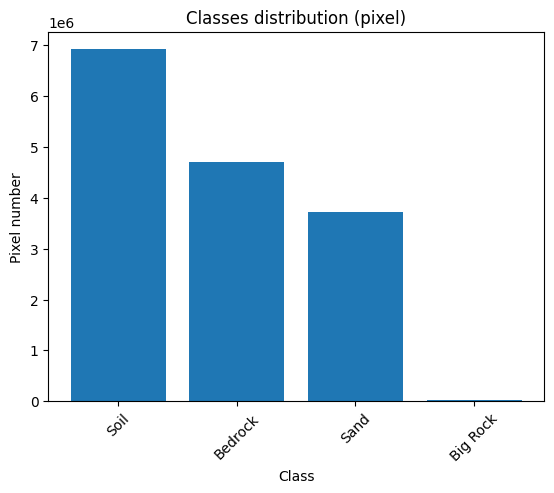


Classes distribution (number of images):
Background: 2047
Soil: 1264
Bedrock: 1136
Sand: 845
Big Rock: 63


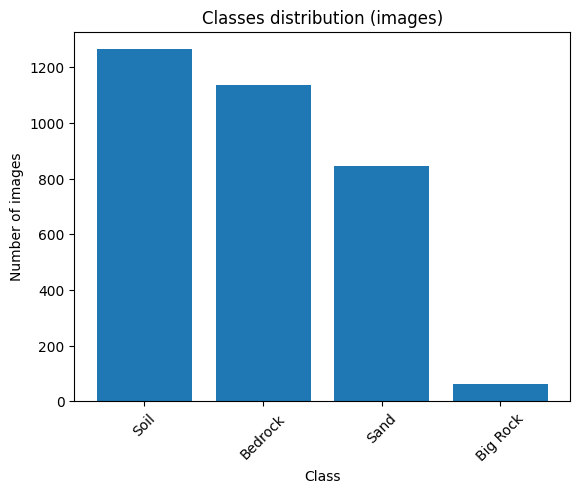

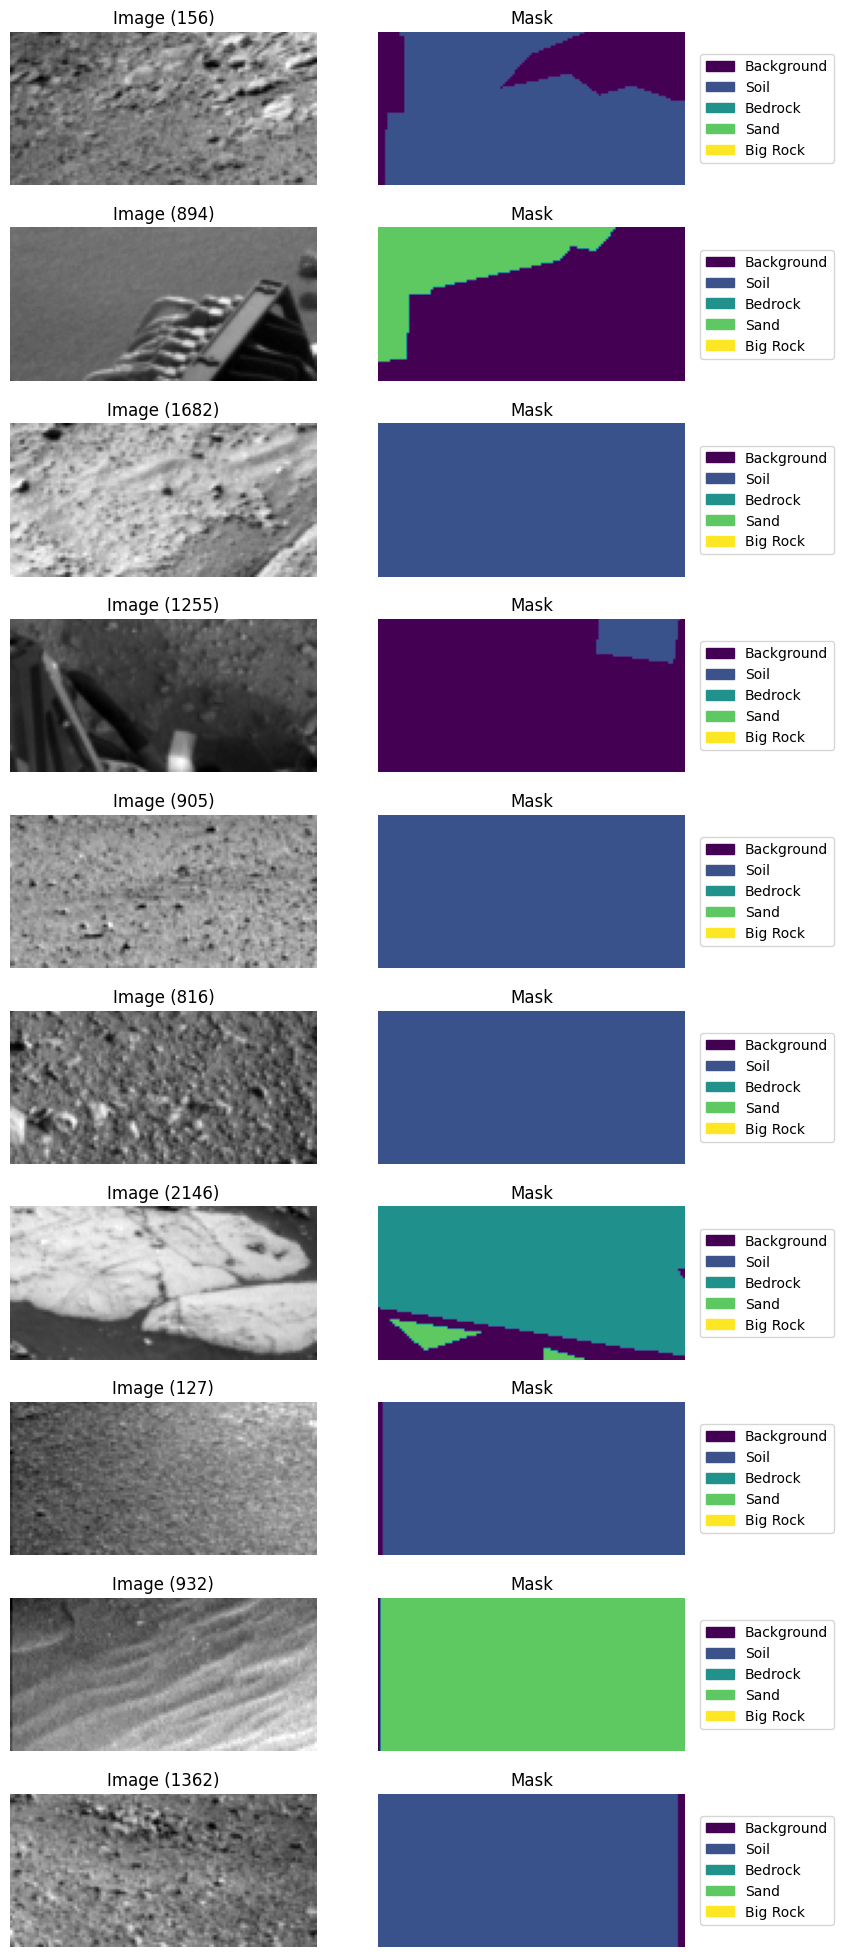

In [5]:
import matplotlib.patches as mpatches

def classes_distribution(y=None):
    if y is None:
        return None

    y_flat = tf.reshape(y, [-1])
    class_counts = tf.math.bincount(y_flat, minlength=num_classes)

    print("Classes distribution (pixel number):")
    for label, count in enumerate(class_counts.numpy()):
        print(f"{labels[label]}: {count} ({round(count / len(y_flat), 2)}%)")

    filtered_labels = {key: value for key, value in labels.items() if value != "Background"}
    filtered_class_counts = [class_counts[key].numpy() for key in filtered_labels.keys()]

    plt.bar(filtered_labels.values(), filtered_class_counts)
    plt.title("Classes distribution (pixel)")
    plt.ylabel("Pixel number")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

    # Calcola il numero di immagini per ciascun tipo di terreno
    soil_images = []
    for terrain_type in labels:
        soil_images.append(len(find_terrain(y, terrain_type)))

    print("\nClasses distribution (number of images):")
    for i in range(len(soil_images)):
        print(f"{labels[i]}: {soil_images[i]}")

    filtered_soil_images = [soil_images[i] for i in filtered_labels.keys()]
    plt.bar(filtered_labels.values(), filtered_soil_images)
    plt.title("Classes distribution (images)")
    plt.ylabel("Number of images")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

def find_terrain(y, terrain_type):
    terrain_present = tf.reduce_any(tf.equal(y, terrain_type), axis=(1, 2))
    return tf.where(terrain_present).numpy().flatten()


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf

def show_random(X, y, X_old=None, y_old=None, times=1):
    cols = 4 if X_old is not None and y_old is not None else 2
    s_old = "Old " if X_old is not None and y_old is not None else ""

    plt.figure(figsize=(cols * 5, times * 2.5))  # Dimensione della figura

    for i in range(times):
        rand_idx = tf.random.uniform([], 0, len(y), dtype=tf.int32).numpy()  # Indice casuale

        # Mostra le immagini e le maschere "old" se presenti
        if X_old is not None and y_old is not None:
            plt.subplot(times, cols, i * cols + 1)
            plt.title(f"{s_old}Image ({rand_idx})")
            plt.imshow(X_old[rand_idx].numpy().squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(times, cols, i * cols + 2)
            plt.title(s_old + "Mask")
            plt.imshow(y_old[rand_idx].numpy().squeeze(), cmap="viridis", vmin=0, vmax=len(labels.values()) - 1)
            plt.axis("off")

        # Mostra le immagini e le maschere correnti
        term = 2 if X_old is not None and y_old is not None else 0
        plt.subplot(times, cols, i * cols + 1 + term)
        plt.title(f"Image ({rand_idx})")
        plt.imshow(X[rand_idx].numpy().squeeze(), cmap="gray")
        plt.axis("off")

        plt.subplot(times, cols, i * cols + 2 + term)
        plt.title("Mask")
        plt.imshow(y[rand_idx].numpy().squeeze(), cmap="viridis", vmin=0, vmax=len(labels.values()) - 1)
        plt.axis("off")

        # Aggiungi legenda (se labels è specificato)
        if labels is not None:
            plt.subplots_adjust(right=0.8)  # Lascia spazio per la legenda
            cmap = plt.cm.viridis  # Usa lo stesso colormap
            colors = [cmap(i / (len(labels.values()) - 1)) for i in range(len(labels.values()))]
            patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels.values())]
            plt.legend(
                handles=patches,
                bbox_to_anchor=(1.05, 0.5),
                loc="center left",
                borderaxespad=0.0
            )

    plt.show()

classes_distribution(y_train)
show_random(X_train, y_train, times=10)

# Dataset split (train/val)

Train set:
X_train.shape = (1971, 64, 128, 1)
y_train.shape = (1971, 64, 128)
Distribuzione classe 4 nel train: 2.38%

Validation set:
X_val.shape = (492, 64, 128, 1)
y_val.shape = (492, 64, 128)
Distribuzione classe 4 nel val: 3.25%
Classes distribution (pixel number):
Background: 3792290 (0.23%)
Soil: 5562395 (0.34%)
Bedrock: 3807781 (0.24%)
Sand: 2966657 (0.18%)
Big Rock: 17309 (0.0%)


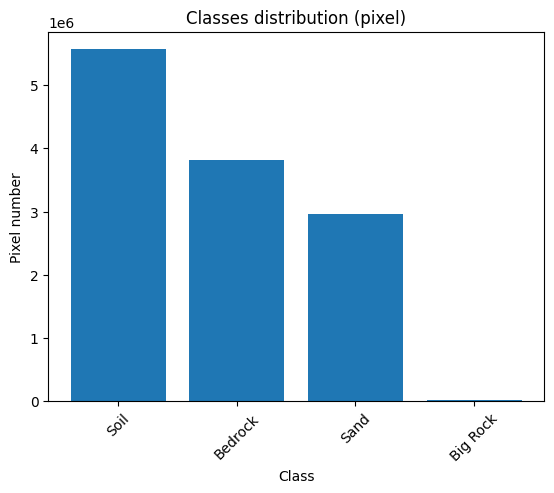


Classes distribution (number of images):
Background: 1637
Soil: 1012
Bedrock: 921
Sand: 676
Big Rock: 47


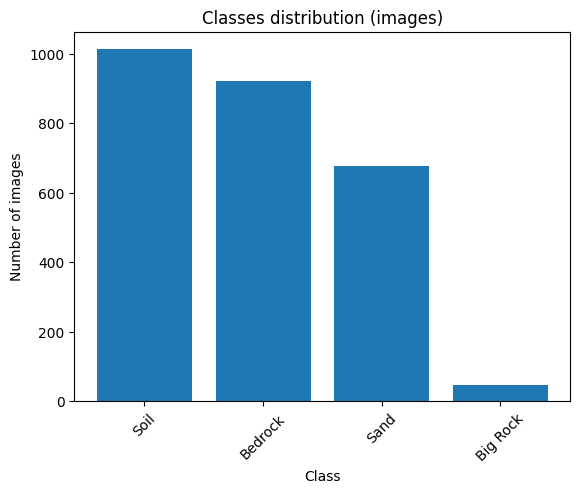

Classes distribution (pixel number):
Background: 1031306 (0.26%)
Soil: 1347574 (0.33%)
Bedrock: 896511 (0.22%)
Sand: 745419 (0.18%)
Big Rock: 9654 (0.0%)


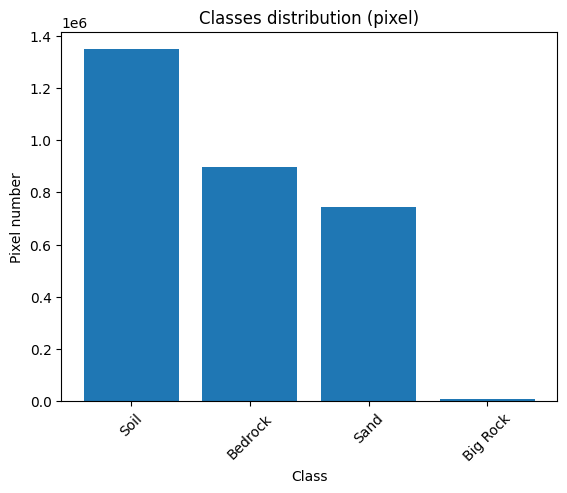


Classes distribution (number of images):
Background: 410
Soil: 252
Bedrock: 215
Sand: 169
Big Rock: 16


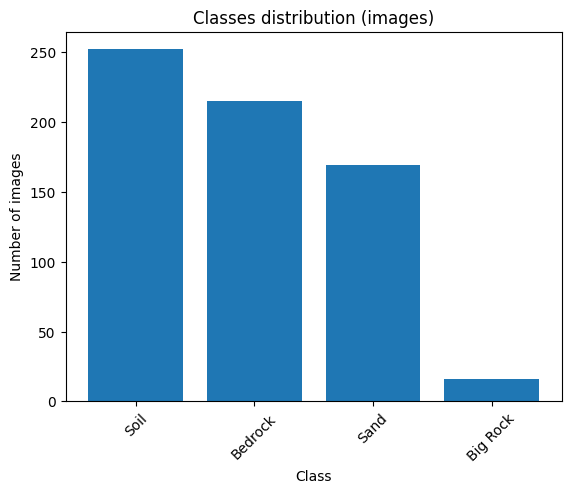

In [6]:
from sklearn.utils import shuffle

def most_frequent_class(mask):
    # Rimuove il canale extra, se c'è
    if len(mask.shape) == 3 :
        mask = tf.squeeze(mask, axis=-1)

    # Converte la maschera in interi
    mask = tf.cast(mask, tf.int32)
    
    # Conta le occorrenze di ciascun valore nella maschera
    class_counts = tf.math.bincount(tf.reshape(mask, [-1]), minlength=tf.reduce_max(mask) + 1)
    
    # Imposta il conteggio della classe 0 a 0 per escluderla
    class_counts = tf.tensor_scatter_nd_update(class_counts, [[0]], [0])
    
    # Trova la classe con il conteggio massimo
    most_frequent = tf.argmax(class_counts)
    
    return tf.cast(most_frequent, tf.int32)

def train_val_split(X, y, val_split = 0.15, seed = 42, class_to_exclude = 0) :
    # Shuffle iniziale per evitare bias nell'ordine dei dati
    X, y = shuffle(X, y, random_state=seed)
    
    # Identifica le immagini con e senza la classe target
    target_class = np.any(y_train == class_to_exclude, axis=(1, 2)) # True se contiene la classe target
    idx_target_class = np.where(target_class)[0]     # Indici delle immagini con la classe target
    idx_no_class = np.where(~target_class)[0]        # Indici delle immagini senza la classe target
    
    # Split per immagini con la classe target
    n_val_class = int(len(idx_target_class) * val_split)
    val_idx_class = idx_target_class[:n_val_class]
    train_idx_class = idx_target_class[n_val_class:]
    
    # Split per immagini senza la classe target
    n_val_no_class = int(len(idx_no_class) * val_split)
    val_idx_no_class = idx_no_class[:n_val_no_class]
    train_idx_no_class = idx_no_class[n_val_no_class:]
    
    # Combina gli indici per il train e il validation set
    train_indices = np.concatenate([train_idx_class, train_idx_no_class])
    val_indices = np.concatenate([val_idx_class, val_idx_no_class])
    
    # Shuffle finale per mescolare i dati
    train_indices = shuffle(train_indices, random_state=seed)
    val_indices = shuffle(val_indices, random_state=seed)
    
    # Crea i set finali
    X_train_split = X[train_indices]
    y_train_split = y[train_indices]
    X_val_split   = X[val_indices]
    y_val_split   = y[val_indices]

    return X_train_split, y_train_split, X_val_split, y_val_split
    
# TODO: rendere la funzione in tf
X_train, y_train, X_val, y_true_val = train_val_split(
    np.array(X_train),
    np.array(y_train),
    val_split,
    seed,
    class_to_exclude=4
)

# Risultati
print("Train set:")
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"Distribuzione classe 4 nel train: {np.mean(np.any(y_train == 4, axis=(1, 2))):.2%}")

print("\nValidation set:")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_true_val.shape}")
print(f"Distribuzione classe 4 nel val: {np.mean(np.any(y_true_val == 4, axis=(1, 2))):.2%}")

X_train = tf.cast(tf.convert_to_tensor(np.stack(X_train)), tf.int32)
X_val   = tf.cast(tf.convert_to_tensor(np.stack(X_val)),   tf.int32)
y_train = tf.cast(tf.convert_to_tensor(np.stack(y_train)), tf.int32)
y_true_val = tf.cast(tf.convert_to_tensor(np.stack(y_true_val)), tf.int32)

classes_distribution(y_train)
classes_distribution(y_true_val)

# Dataset split (one-class images)

In [7]:
def filter_masks_by_class(masks, threshold_percentage):
    # Calcola il numero totale di pixel per maschera
    total_pixels = tf.cast(tf.size(masks[0]), tf.float32)

    # Conta i pixel per ciascuna classe in ogni maschera
    unique_classes = tf.reduce_max(masks) + 1
    class_counts = tf.stack([
        tf.reduce_sum(tf.cast(masks == class_id, tf.float32), axis=[1, 2])
        for class_id in range(unique_classes)
    ], axis=1)

    # Calcola la percentuale di pixel per ciascuna classe
    class_percentages = (class_counts / total_pixels) * 100

    # Trova la percentuale massima per ogni maschera
    max_percentages = tf.reduce_max(class_percentages, axis=1)

    # Identifica le maschere con una classe predominante sopra la soglia
    above_threshold = tf.where(max_percentages > threshold_percentage)[:, 0]
    below_or_equal_threshold = tf.where(max_percentages <= threshold_percentage)[:, 0]

    return tf.cast(above_threshold, tf.int32), tf.cast(below_or_equal_threshold, tf.int32)

t_above, t_below = filter_masks_by_class(y_train,    threshold_percentage)
v_above, v_below = filter_masks_by_class(y_true_val, threshold_percentage)

X_train_1, X_train_2 = tf.gather(X_train, t_above), tf.gather(X_train, t_below)
X_val_1, X_val_2 = tf.gather(X_val, v_above), tf.gather(X_val, v_below)

y_train_1, y_train_2 = tf.gather(y_train, t_above), tf.gather(y_train, t_below)
y_val_1, y_val_2 = tf.gather(y_true_val, v_above), tf.gather(y_true_val, v_below)

print(f"One-class images -> Train: {t_above.shape[0]}, val: {v_above.shape[0]}")
print(f"Other images -> Train: {t_below.shape[0]}, val: {v_below.shape[0]}")

One-class images -> Train: 1385, val: 354
Other images -> Train: 586, val: 138


# Loss functions

In [8]:
def resize_mask(masks, target_size):

    if masks.shape[1:3] == target_size:
        return masks
    
    masks = tf.expand_dims(masks, axis=-1)
    
    def resize_single(mask):
        return tf.image.resize(mask, target_size, method='nearest')
    
    resized_masks = tf.map_fn(
        resize_single,
        masks,
        fn_output_signature=tf.float32
    )
    
    return tf.squeeze(resized_masks, axis=-1)

def dice_loss(y_true, y_true_one_hot, y_pred, class_weights=None):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred * mask[..., None], axis=[1, 2])
    denominator = tf.reduce_sum((y_true_one_hot + y_pred) * mask[...,None], axis=[1, 2]) + tfk.backend.epsilon()

    # Calcola il Dice score per ogni classe
    dice_per_class = numerator / denominator  # Shape: (batch_size, num_classes)
    
    # Applica i pesi di classe
    if class_weights is not None:
        dice_per_class *= class_weights  # Shape: (batch_size, num_classes)
        
    d_loss = 1 - tf.reduce_mean(dice_per_class, axis=-1)

    return tf.reduce_mean(d_loss)

def focal_loss(y_true, y_true_one_hot, y_pred, class_weights=None, gamma=2.0):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    y_pred = tf.clip_by_value(y_pred, tfk.backend.epsilon(), 1 - tfk.backend.epsilon())
    cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
    
    # Apply class weights
    if class_weights is not None:
        weights = tf.reduce_sum(class_weights * y_true_one_hot, axis=-1)  # Shape: (batch_size, height, width)
        cross_entropy *= weights[..., None]  # Shape: (batch_size, height, width, num_classes)
    
    mod_factor = 0.25 * (1 - y_pred) ** gamma
    f_loss = tf.reduce_mean(mod_factor * cross_entropy * mask[..., None])
    return f_loss

def boundary_loss(y_true, y_true_one_hot, y_pred):
    # Genera una maschera per escludere il background
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    
    # Calcola i gradienti dei bordi della predizione
    sobel_x_pred = tf.image.sobel_edges(y_pred)[..., 0]
    sobel_y_pred = tf.image.sobel_edges(y_pred)[..., 1]
    grad_pred = tf.sqrt(tf.square(sobel_x_pred) + tf.square(sobel_y_pred) + tfk.backend.epsilon())
    
    # Calcola i gradienti dei bordi del ground-truth
    sobel_x_true = tf.image.sobel_edges(y_true_one_hot)[..., 0]
    sobel_y_true = tf.image.sobel_edges(y_true_one_hot)[..., 1]
    grad_true = tf.sqrt(tf.square(sobel_x_true) + tf.square(sobel_y_true) + tfk.backend.epsilon())
    
    # Normalizza i gradienti per evitarne l'influenza sproporzionata
    grad_pred = grad_pred / (tf.reduce_max(grad_pred, axis=[1, 2, 3], keepdims=True) + tfk.backend.epsilon())
    grad_true = grad_true / (tf.reduce_max(grad_true, axis=[1, 2, 3], keepdims=True) + tfk.backend.epsilon())
    
    # Calcola la differenza assoluta tra i bordi normalizzati
    boundary_diff = tf.abs(grad_pred - grad_true)
    
    # Applica la maschera per penalizzare solo i bordi validi
    boundary_loss = tf.reduce_mean(boundary_diff * mask[..., None])  # Considera solo i pixel non di background
    
    return boundary_loss

def weights_loss(y_true, y_pred, class_weights):
        # Assicurati che y_true sia intero
        y_true = tf.cast(y_true, tf.int32)
        
        # Converte y_true in one-hot encoding
        one_hot = tf.one_hot(y_true, depth=len(class_weights), dtype=tf.float32)  # Shape: (batch_size, height, width, num_classes)

        # Calcola il peso per ogni pixel
        weighted_map = tf.reduce_sum(one_hot * class_weights, axis=-1)  # Shape: (batch_size, height, width)

        # Calcola la cross-entropia tra logit e one-hot labels
        loss = tfk.losses.CategoricalCrossentropy()(one_hot, y_pred)
        #loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=y_pred)
        
        # Applica i pesi e calcola la media
        weighted_loss = loss * weighted_map

        # Media pesata solo sui pixel validi
        return tf.reduce_mean(weighted_loss)

def combined_loss_wrapper(class_weights, c_dice=0.0, c_focal=0.0, c_boundary=0.0, c_weights=0.0):
    assert c_dice + c_focal + c_boundary + c_weights == 1.0, "Loss weights must sum to 1.0"
    
    class_weights = tf.convert_to_tensor(class_weights, dtype=tf.float32)
    
    def combined_loss(y_true, y_pred):

        resized_preds = []

        # Resize if we are in a deep layer
        target_size = y_pred.shape[1:3]  # Ottieni altezza e larghezza della feature map
        y_true = resize_mask(y_true, target_size)  # Ridimensiona la maschera
        y_true = tf.cast(y_true, tf.int32)

        if y_true.shape[-1] == 1:
            y_true = tf.squeeze(y_true)
        
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1], dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, tfk.backend.epsilon(), 1 - tfk.backend.epsilon())

        focal    = c_focal    * focal_loss(y_true, y_true_one_hot, y_pred, class_weights=class_weights)
        dice     = c_dice     * dice_loss(y_true, y_true_one_hot, y_pred, class_weights=class_weights)
        boundary = c_boundary * boundary_loss(y_true, y_true_one_hot, y_pred)
        weights  = c_weights  * weights_loss(y_true, y_pred, class_weights)
        
        return dice + focal + boundary + weights
            
    return combined_loss

# Balance strategies

Here we can put different strategies (only one must be active) to try the best one for our model

## Weights balance

In [9]:
def transform_weights(class_weights, num_classes, max_weight=20.0) :
    class_weights = np.array(class_weights)
    class_weights[0] /= 3
    class_weigths = tf.convert_to_tensor(class_weights)
    # Log-scaling dei pesi
    #class_weights = tf.math.log(1 + class_weights)

    class_weights = tf.minimum(class_weights, max_weight)

    class_weights /= tf.reduce_sum(class_weights) / num_classes

    return class_weights

def compute_weights(y, num_classes, max_weight=20.0) :
    y_flat = tf.reshape(y_train, [-1])

    class_counts = tf.math.bincount(y_flat, minlength=num_classes, maxlength=num_classes, dtype=tf.float32)
    
    total_pixels = tf.reduce_sum(class_counts)
    class_weights = total_pixels / (class_counts * num_classes)
    
    return transform_weights(class_weights, num_classes, max_weight)

def evaluate_weights(class_weights, labels, num_classes=5) :
    print("\nClass weights:")
    for i in range(num_classes):
        label = labels[i] if i in labels else f"Class {i}"
        weight = float(class_weights[i].numpy())
        if i == 1 or i == 3:
            print(f"  {label}\t\t: {round(weight, 2)}")
        else:
            print(f"  {label}\t: {round(weight, 2)}")
    
    weights_list = [class_weights[i] for i in range(class_weights.shape[0])]

    return weights_list

class_weights = tf.ones(5, dtype=tf.float32)
weights_list = []
if balance_mode == "weights" or balance_mode == "mixed":
    class_weights = compute_weights(y_train, num_classes, max_weight)
    weights_list = evaluate_weights(class_weights, labels)

#low_loss   = combined_loss_wrapper(weights_list, c_focal=0.7, c_weights=0.3)
inter_loss = combined_loss_wrapper(weights_list, c_dice=0.2, c_weights=0.8)
main_loss  = combined_loss_wrapper(weights_list, c_dice=0.7, c_focal=0.3)
#inter_loss = combined_loss_wrapper(weights_list, c_boundary=1.0)
#low_loss   = combined_loss_wrapper(weights_list, c_boundary=1.0)
#main_loss  = combined_loss_wrapper(weights_list, c_boundary=1.0)


Class weights:
  Background	: 0.18
  Soil		: 0.37
  Bedrock	: 0.54
  Sand		: 0.7
  Big Rock	: 3.2


## Oversampling with data augmentation

### Data augmentation

In [10]:
def augment_flip_horizontal(image, mask):
    """Apply horizontal flip to image and mask."""
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

    return image, mask

def augment_random_zoom(image, mask, zoom_range=(1.0, 1.3)):
    """Apply random zoom to image and mask."""
    scale = tf.random.uniform([], zoom_range[0], zoom_range[1])

    height, width = 64, 128
    new_height, new_width = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32), tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
    image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    mask = tf.image.resize(mask, [new_height, new_width], method='nearest')
    
    # Crop or pad back to original size
    image = tf.image.resize_with_crop_or_pad(image, height, width)
    mask = tf.image.resize_with_crop_or_pad(mask, height, width)
    
    return image, mask

def augment_add_noise(image, mask, noise_factor=15):
    """Add random noise to image."""
    noise_factor /= 1000
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)  # Ensure pixel values remain between 0 and 1

    return image, mask

def augment_random_contrast(image, mask, contrast_range=(0.8, 1.2)):
    """Apply random contrast adjustment to image."""
    image = tf.image.random_contrast(image, contrast_range[0], contrast_range[1])

    return image, mask

def augment_random_brightness(image, mask, max_delta=15):
    """Apply random brightness adjustment to image."""
    max_delta /= 100
    
    image = tf.image.random_brightness(image, max_delta)

    return image, mask

def augment_random_crop(image, mask, crop_size=(64, 128)):
    """Apply random crop to image and mask."""
    combined = tf.concat([image, tf.cast(mask, tf.float32)], axis=-1)
    combined = tf.image.random_crop(combined, size=(crop_size[0], crop_size[1], tf.shape(combined)[-1]))
    image, mask = combined[..., :-1], combined[..., -1:]

    return image, mask

def invert_color(image, mask):
    return 1.0 - image, mask

def augment_image(image, mask):
    """Apply a random set of augmentations to image and mask."""
    
    image = tf.cast(image, dtype=tf.float32)
    mask  = tf.cast(mask,  dtype=tf.int32)
    
    exp_img, exp_mask = False, False
    if len(image.shape) == 2 :
        image = tf.expand_dims(image, axis=-1)
        exp_img = True
    if len(mask.shape) == 2 :
        mask = tf.expand_dims(mask, axis=-1)
        exp_mask = True

    image_type = most_frequent_class(mask)

    noise_factor = 5.0
    zoom_min, zoom_max = (1.0, 1.3)
    brightness_factor = 10.0
    shear_range = 0.2
    prob_term = 0.0
    contrast_range = (0.8, 1.2)
    
    # Horizontal flip
    if tf.cast(tf.random.uniform(()) < 0.5, tf.bool) :
        image, mask = augment_flip_horizontal(image, mask)
    
    if image_type == 4 :
        noise_factor = 10.0
        zoom_min, zoom_max = (1.0, 1.2)
        shear_range = 0.0
        prob_term = 1.0

    if image_type == 1: # Soil
        noise_factor = 10.0
        zoom_min, zoom_max = (1.0, 1.5)
        shear_range = 0.0
        prob_term = -0.1

    if image_type == 2: # Bedrock
        noise_factor = 5.0
        zoom_min, zoom_max = (1.0, 1.8)
        shear_range = 0.0
        prob_term = 0.1

    if image_type == 3: # Sand
        noise_factor = 10.0
        zoom_min, zoom_max = (1.5, 2.0)
        shear_range = 0.0
        prob_term = 0.2
        
    # Random brightness
    if tf.random.uniform(()) < 0.2 :
        image, mask = augment_random_brightness(image, mask, 10.0)

    # Random contrast
    if tf.random.uniform(()) < 0.3 :
        image, mask = augment_random_contrast(image, mask, (0.3, 2.5))

    # Invert color
    if tf.random.uniform(()) < 0.2 + prob_term :
        image, mask = invert_color(image, mask)
    
    # Random zoom
    if tf.random.uniform(()) < 0.2 + prob_term :
        image, mask = augment_random_zoom(image, mask, (zoom_min, zoom_max))
    
    # Gaussian noise
    if tf.random.uniform(()) < 0.2 + prob_term :
        image, mask = augment_add_noise(image, mask, noise_factor)

    # Return processing
    if exp_img :
        image = image[:,:,0]
    if exp_mask :
        mask = mask[:,:,0]
    return image, mask

In [11]:
def process_augmentation(X_train, y_train) :
    
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    augmented_dataset = dataset.map(lambda img, mask : augment_image(img,mask), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    augmented_X_train = []
    augmented_y_train = []
    
    for augmented_images, augmented_masks in augmented_dataset:
        augmented_X_train.append(augmented_images)
        augmented_y_train.append(augmented_masks)
    
    augmented_X_train = tf.convert_to_tensor(augmented_X_train, dtype=tf.int32)
    augmented_y_train = tf.convert_to_tensor(augmented_y_train, dtype=tf.int32)
    
    return augmented_X_train, augmented_y_train

if balance_mode == "oversampling" or balance_mode == "mixed":
    from math import floor
    
    def oversample(X, y, target_class, times=2.0):
    
        assert times > 1.0

        train_set = tf.stack([X[:,:,:,0], y], axis=1)  # Shape: (n_samples, 2, height, width)
    
        target_indices = tf.where(tf.reduce_any(y == target_class, axis=[1, 2]))
        target_indices = target_indices[:, 0]
    
        few_data = tf.gather(train_set, target_indices)

        if overs_ignore_classes == True :
            few_data_masks = tf.where(few_data[:, 1, :, :] == target_class, target_class, 0)
            few_data = tf.stack([few_data[:, 0, :, :], few_data_masks], axis=1)
    
        num_full_copies = floor(times - 1)
            
        tiled_data = tf.tile(few_data, [num_full_copies, 1, 1, 1])
    
        result_data = tf.concat([train_set, tiled_data], axis=0)
    
        remainder = times - 1 - num_full_copies
        
        if remainder > 0:
            shuffled_indices = tf.random.shuffle(target_indices)
            num_remainder_samples = int(remainder * len(target_indices))
            remainder_indices = shuffled_indices[:num_remainder_samples]

            remainder_data  = tf.gather(train_set, remainder_indices)
            remainder_masks = tf.where (remainder_data[:, 1, :, :] == target_class, target_class, 0)
            remainder_data  = tf.stack ([remainder_data[:, 0, :, :], remainder_masks], axis=1)

            result_data = tf.concat([result_data, remainder_data], axis=0)

        if overs_augmentation :
            augmented_images, augmented_masks = process_augmentation(result_data[:, 0], result_data[:, 1])
            result_data = tf.stack([augmented_images, augmented_masks], axis=1)
    
        # Mescola i dati finali
        shuffled_result = tf.random.shuffle(result_data)

        # Dividi di nuovo in X e y
        X_result = shuffled_result[:, 0, :, :]
        X_result = tf.expand_dims(X_result, axis=-1)
        y_result = shuffled_result[:, 1, :, :]

        return X_result, y_result
        
    classes_to_oversample = [4]
    
    times_list = [3]
    
    assert len(times_list) == len(classes_to_oversample)
    
    for type, times in zip(classes_to_oversample, times_list) :
        print(f"Processing {labels[type]} {times} times...")
        X_train, y_train = oversample(X_train, y_train, type, times)
        print(f"Train samples: {X_train.shape}\n")
    
    if balance_mode == "mixed":
        class_weights = compute_weights(y_train, num_classes, max_weight)
        # log-scaling per appianare le sovrabbondanze dell'oversampling
        class_weights = tf.math.log(1 + class_weights)
        loss, weights_list = evaluate_weights(class_weights, labels)
    
n_samples = len(y_train)

# (Deprecated) Data augmentation of the training set

In [12]:
#X_old, y_old = X_train, y_train
if False :
    X_train, y_train = process_augmentation(X_train, y_train)

In [13]:
if False:#augmentation or balance_mode == "oversampling" or balance_mode == "mixed":
    show_random(X_train, y_train, X_old, y_old, 20)

# Re-analysis of the classes distribution

In [14]:
if balance_mode == "oversampling" or balance_mode == "mixed":
    classes_distribution(y_train)

# BLOCK FUNCTIONS

## Adaptive feature fusion

In [15]:
def adaptive_feature_fusion(f1, f2):
    return tfkl.Concatenate(axis=-1)([f1,f2])

## Gating

In [16]:
def gating_block(encoder_features, decoder_features):
    # Assicurati che abbiano lo stesso numero di canali (C1 = C2)
    if encoder_features.shape[-1] != decoder_features.shape[-1]:
        decoder_features = tfkl.Conv2D(
            encoder_features.shape[-1], 
            kernel_size=1, 
            activation=None
        )(decoder_features)
    
    # Concatenazione delle feature per calcolare i pesi di gating
    combined_features = tfkl.Concatenate(axis=-1)([encoder_features, decoder_features])
    combined_features = normalization(combined_features, "group")

    # Gating mechanism: calcolo dei pesi
    gate = tfkl.Conv2D(
        encoder_features.shape[-1], 
        kernel_size=1, 
        activation='sigmoid'
    )(combined_features)  # Pesi nel range [0, 1] per ciascun canale

    # Applicazione dei pesi
    gated_encoder = gate * encoder_features
    gated_decoder = (1 - gate) * decoder_features

    # Somma pesata finale
    gated_features = gated_encoder + gated_decoder

    return gated_features

## Dilated convolutional blocks

In [17]:
def dilated_conv_block(inputs, filters, dilation_rates=[1, 2, 4, 8]):
    convs = []
    for rate in dilation_rates:
        conv = tfkl.Conv2D(filters, (3, 3), dilation_rate=rate, padding="same")(inputs)
        conv = normalization(conv, "group")
        conv = tfkl.LeakyReLU(negative_slope=0.2)(conv)
        convs.append(conv)
    x = tfkl.Concatenate()(convs)
    return x

## PPM

In [18]:
def pyramid_pooling_module(inputs, pool_sizes=[1, 2, 4, 8], filters=512):
    input_size = inputs.shape[1:3]
    if None in input_size:
        raise ValueError("Input size must be fully defined.")

    feature_maps = []
    for pool_size in pool_sizes:
        # Salta pool_size non compatibili
        if input_size[0] < pool_size or input_size[1] < pool_size:
            continue
            
        # Esegui il pooling adattivo
        pooled = tfkl.AveragePooling2D(pool_size=(pool_size, pool_size))(inputs)
        pooled = tfkl.Conv2D(filters, kernel_size=1, padding="same", use_bias=False)(pooled)
        pooled = normalization(pooled, "instance")
        pooled = tfkl.LeakyReLU(negative_slope=0.2)(pooled)
        
        upsampling_factor = pool_size
        upsampled = tfkl.UpSampling2D(size=upsampling_factor, interpolation="bilinear")(pooled)
 
        feature_maps.append(upsampled)

    # Aggiungi l'input originale
    feature_maps.append(inputs)
    
    # Concatenate lungo il canale
    return tfkl.Concatenate()(feature_maps)

## Attentions

In [19]:
def align_filters(l1, l2):
    target_filters = max(l1.shape[-1], l2.shape[-1])
    # Align the number of filters
    l1 = tfkl.Conv2D(target_filters, (1, 1), padding="same")(l1)
    l2 = tfkl.Conv2D(target_filters, (1, 1), padding="same")(l2)

    return l1, l2

def spatial_attention_block(inputs):
    # Apply 2D Convolution to spatial dimensions
    spatial_attention = tfkl.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(inputs)
    spatial_attention = normalization(spatial_attention, "group")
    # Apply attention
    spatial_attention = tfkl.Multiply()([inputs, spatial_attention])
    return spatial_attention

def attention_block(inputs, num_filters):
    x = spatial_attention_block(inputs=inputs)
    return x

def cross_branch_attention(branch1, branch2):
    """Cross-Branch Attention Block"""
    branch1, branch2 = align_filters(branch1, branch2)
    
    # Compute cross-attention weights
    attention_weights1 = tfkl.GlobalAveragePooling2D()(branch1)
    attention_weights1 = tfkl.Dense(branch2.shape[-1], activation="sigmoid")(attention_weights1)

    attention_weights2 = tfkl.GlobalAveragePooling2D()(branch2)
    attention_weights2 = tfkl.Dense(branch1.shape[-1], activation="sigmoid")(attention_weights2)

    # Apply attention weights
    branch1_attended = tfkl.Multiply()([branch1, tfkl.Reshape((1, 1, branch1.shape[-1]))(attention_weights2)])
    branch2_attended = tfkl.Multiply()([branch2, tfkl.Reshape((1, 1, branch2.shape[-1]))(attention_weights1)])

    # Combine branches
    branch1_output = tfkl.Add()([branch1, branch2_attended])
    branch2_output = tfkl.Add()([branch2, branch1_attended])

    return branch1_output, branch2_output

## S&E

In [20]:
def squeeze_and_excitation(inputs, reduction_ratio=16):
    filters = inputs.shape[-1]
    se = tfkl.GlobalAveragePooling2D(keepdims=True)(inputs)
    se = tfkl.Dense(filters // reduction_ratio, activation="relu")(se)
    se = tfkl.Dropout(dropout_rate)(se)
    se = tfkl.Dense(filters, activation="sigmoid")(se)
    return tfkl.Multiply()([inputs, se])

## Normalizations

In [21]:
def normalization(x, type="batch"):
    return x
    if type == "batch":
        return tfkl.BatchNormalization()(x)
    if type == "group":
        groups = min(32, x.shape[-1])
        return tfkl.GroupNormalization(groups=groups)(x)
    if type == "instance":
        return tfkl.LayerNormalization(axis=[1, 2])(x)
    if type == "layer" :
        return tfkl.LayerNormalization()(x)

    return x

## Encoders

In [22]:
from tensorflow.keras import regularizers

def simple_encoder(inputs, filters):
    conv = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    conv = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu')(conv)
    pool = tfkl.MaxPooling2D((2, 2))(conv)
    return pool, conv
    
def complex_encoder(inputs, filters):
    x = dilated_conv_block(inputs, filters)
    x = dilated_conv_block(x, filters)
    p = tfkl.MaxPooling2D((2, 2))(x)
    return p, x

def inception_encoder(inputs, filters):
    # Branch 1: 1x1 convolution
    branch1 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(inputs)
    branch1 = normalization(branch1, "group")

    # Branch 2: 1x1 followed by 3x3 with dilation
    branch2 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(inputs)
    branch2 = normalization(branch2, "group")
    branch2 = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu", dilation_rate=2)(branch2)
    branch2 = normalization(branch2, "group")

    # Branch 3: 1x1 followed by 5x5 with dilation
    branch3 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(inputs)
    branch3 = normalization(branch3, "group")
    branch3 = tfkl.Conv2D(filters, (5, 5), padding="same", activation="relu", dilation_rate=3)(branch3)
    branch3 = normalization(branch3, "group")

    # Branch 4: 3x3 max pooling followed by 1x1
    branch4 = tfkl.MaxPooling2D((3, 3), strides=1, padding="same")(inputs)
    branch4 = normalization(branch4, "group")
    branch4 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(branch4)
    branch4 = normalization(branch4, "group")

    # Concatenate all branches
    x = tfkl.Concatenate()([branch1, branch2, branch3, branch4])

    # Pooling
    p = tfkl.MaxPooling2D((2, 2))(x)
    
    return p, x
    
def residual_encoder(inputs, filters):
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(inputs)
    x = normalization(x, "group")
    
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, "group")
    
    shortcut = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(inputs)
    shortcut = normalization(shortcut, "group")
    
    x = tfkl.Concatenate(axis=-1)([x, shortcut])
    x = normalization(x, "group")

    p = tfkl.MaxPooling2D((2, 2))(x)
    return p, x

## Bottleneck

In [23]:
def residual_bottleneck(inputs, filters):
    x = tfkl.Conv2D(filters // 4, (1, 1), padding="same", activation="relu")(inputs)
    x = normalization(x, "instance")

    x = tfkl.Conv2D(filters // 4, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, "instance")
    
    x = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    x = normalization(x, "instance")

    shortcut = inputs  # Connessione residua
    shortcut = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(shortcut)
    shortcut = normalization(shortcut, "instance")
    
    # Aggiungi la shortcut
    x = tfkl.Concatenate(axis=-1)([x, shortcut])
    x = normalization(x, "instance")
    
    return x

def inception_bottleneck(inputs, filters):
    # Branch 1: 1x1 convolution
    branch1 = tfkl.Conv2D(filters // 4, (1, 1), padding="same", activation="relu")(inputs)
    branch1 = normalization(branch1, "instance")

    # Branch 2: 1x1 followed by 3x3
    branch2 = tfkl.Conv2D(filters // 4, (1, 1), padding="same", activation="relu")(inputs)
    branch2 = normalization(branch2, "instance")
    branch2 = tfkl.Conv2D(filters // 4, (3, 3), padding="same", activation="relu")(branch2)
    branch2 = normalization(branch2, "instance")

    # Branch 3: 1x1 followed by 5x5
    branch3 = tfkl.Conv2D(filters // 4, (1, 1), padding="same", activation="relu")(inputs)
    branch3 = normalization(branch3, "instance")
    branch3 = tfkl.Conv2D(filters // 4, (5, 5), padding="same", activation="relu")(branch3)
    branch3 = normalization(branch3, "instance")

    # Branch 4: 3x3 max pooling followed by 1x1
    branch4 = tfkl.MaxPooling2D((3, 3), strides=1, padding="same")(inputs)
    branch4 = tfkl.Conv2D(filters // 4, (1, 1), padding="same", activation="relu")(branch4)
    branch4 = normalization(branch4, "instance")

    # Concatenate all branches
    x = tfkl.Concatenate()([branch1, branch2, branch3, branch4])

    return x

def transformer_bottleneck(inputs, num_heads=8, key_dim=64, ff_dim=256):
    # Self-Attention
    attention = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = tfkl.Concatenate(axis=-1)([inputs, attention])  # Residual connection
    attention = normalization(attention, "layer")
    
    # Feedforward network
    ffn = tfkl.Dense(ff_dim, activation="relu")(attention)
    ffn = tfkl.Dense(inputs.shape[-1])(ffn)
    output = tfkl.Concatenate(axis=-1)([attention, ffn])  # Residual connection
    output = normalization(output, "layer")
    
    return output

## Decoders

In [24]:
def simple_decoder(inputs, skip_features, filters):
    up = tfkl.UpSampling2D((2, 2))(inputs)
    up = tfkl.Concatenate()([up, skip_features])
    conv = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu')(up)
    conv = tfkl.Conv2D(filters, (3, 3), padding='same', activation='relu')(conv)
    return conv
    
def complex_decoder(inputs, skip_features, filters, mode=""):
    x = tfkl.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same")(inputs)
    
    x = tfkl.Concatenate(axis=-1)([x, skip_features])
        
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, "group")
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, "group")
    return x

def inception_decoder(inputs, skip_features, filters, mode="", norm_type="group"):
    # Upsampling
    x = tfkl.UpSampling2D((2, 2))(inputs)

    x = tfkl.Concatenate(axis=-1)([x, skip_features])

    # Inception module
    branch1 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    branch1 = normalization(branch1, norm_type)
    
    branch2 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    branch2 = normalization(branch2, norm_type)
    branch2 = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(branch2)
    branch2 = normalization(branch2, norm_type)
    
    branch3 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    branch3 = normalization(branch3, norm_type)
    branch3 = tfkl.Conv2D(filters, (5, 5), padding="same", activation="relu")(branch3)
    branch3 = normalization(branch3, norm_type)
    
    branch4 = tfkl.MaxPooling2D((3, 3), strides=1, padding="same")(x)
    branch4 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(branch4)
    branch4 = normalization(branch4, norm_type)

    # Concatenate all branches
    x = tfkl.Concatenate()([branch1, branch2, branch3, branch4])

    return x

def residual_decoder(inputs, skip_features, filters, mode="", norm_type="instance"):
    x = tfkl.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same")(inputs)

    x = tfkl.Concatenate(axis=-1)([x, skip_features])
    
    shortcut = x  # Connessione residua
    
    # Convoluzione principale
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, norm_type)
    
    x = tfkl.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = normalization(x, norm_type)
    
    shortcut = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(shortcut)
    shortcut = normalization(shortcut, norm_type)
    
    x = tfkl.Concatenate(axis=-1)([x, shortcut])  # Connessione residua
    x = normalization(x, norm_type)
        
    return x

# Build the model

In [25]:
def build_segmentation_model(input_shape, num_classes):
    
    start_input = tfkl.Input(shape=input_shape, name="start_input")
    inter_input = tfkl.Input(shape=input_shape, name="inter_input")

    # Encoder: Downsampling
    e1_1, f1_1 = simple_encoder(start_input, bfs // 16)
    e2_1, f2_1 = simple_encoder(e1_1, bfs // 8)
    e3_1, f3_1 = simple_encoder(e2_1, bfs // 4)
    e4_1, f4_1 = complex_encoder(e3_1, bfs // 2)

    # Bottleneck: Feature compression
    b1 = inception_bottleneck(e4_1,bfs)

    # Decoder: Upsampling
    d4_1 = complex_decoder(b1, f4_1, bfs // 2)
    d3_1 = simple_decoder(d4_1, f3_1, bfs // 4)
    d2_1 = simple_decoder(d3_1, f2_1, bfs // 8)
    d1_1 = simple_decoder(d2_1, f1_1, bfs // 16)

    # Output della prima U-Net (mappa intermedia)
    half_output = tfkl.Conv2D(num_classes, (1, 1), activation="softmax")(d1_1)
    
    c1 = tfkl.Concatenate(axis=-1)([half_output, inter_input])

    # Encoder: Downsampling
    e1_2, f1_2 = simple_encoder(c1, bfs // 16)
    #_, e1_2 = cross_branch_attention(e1_1, e1_2)
    
    e2_2, f2_2 = simple_encoder(e1_2, bfs // 8)
    #_, e2_2 = cross_branch_attention(e2_1, e2_2)
    
    e3_2, f3_2 = simple_encoder(e2_2, bfs // 4)
    #_, e3_2 = cross_branch_attention(e3_1, e3_2)
    
    e4_2, f4_2 = complex_encoder(e3_2, bfs // 2)
    #_, e4_2 = cross_branch_attention(e4_1, e4_2)

    # Bottleneck: Feature compression
    b2 = tfkl.Concatenate(axis=-1)([b1, e4_2])
    b2 = residual_bottleneck(e4_2, bfs)

    # Decoder: Upsampling
    d4_2 = complex_decoder(b2, f4_2, bfs // 2)
    d3_2 = simple_decoder(d4_2, f3_2, bfs // 4)
    d2_2 = simple_decoder(d3_2, f2_2, bfs // 8)
    d1_2 = simple_decoder(d2_2, f1_2, bfs // 16)
    
    # Outputs
    
    #b_output     = tfkl.Conv2D(num_classes, (1, 1), activation="softmax", name="b_output")(b1)
    inter_output = tfkl.Conv2D(num_classes, (1, 1), activation="softmax", name="inter_output")(half_output)
    main_output  = tfkl.Conv2D(num_classes, (1, 1), activation="softmax", name="main_output")(d1_2)

    # Define the model
    model = models.Model(inputs=[start_input, inter_input], outputs=[inter_output, main_output])
    
    return model

# Customized metric

In [26]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="MeanIntersectionOverUnion")
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self,
        num_classes,
        class_weights=None,
        labels_to_exclude=None,
        ignore_class=None,
        sparse_y_true=True,
        sparse_y_pred=True,
        axis=-1,
        name="cmean_iou",
        dtype=None,
        **kwargs
    ):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_class = ignore_class
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis
        self.class_weights = class_weights
        
        # Default to excluding label 0 if no exclusions are provided
        self.labels_to_exclude = labels_to_exclude if labels_to_exclude is not None else [0]
        
        # Initialize class weights
        if class_weights is not None:
            self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        else:
            # Default weights: all classes treated equally
            self.class_weights = tf.ones(num_classes, dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        mask = ~tf.reduce_any([y_true == label for label in self.labels_to_exclude], axis=0)
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = tf.boolean_mask(y_pred, mask)

        # Ensure y_true is int32 for indexing
        y_true = tf.cast(y_true, tf.int32)

        # Apply class weights
        if self.class_weights is not None:
            weights = tf.gather(self.class_weights, y_true)
            sample_weight = weights if sample_weight is None else sample_weight * weights

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        config = super().get_config()
        config.update({
            'ignore_class': self.ignore_class,
            'sparse_y_true': self.sparse_y_true,
            'sparse_y_pred': self.sparse_y_pred,
            'axis': self.axis,
            'labels_to_exclude': self.labels_to_exclude,
            'class_weights': self.class_weights.numpy().tolist() if self.class_weights is not None else None,
        })
        return config

    @classmethod
    def from_config(cls, config):
        class_weights = config.pop('class_weights', None)
        if class_weights is not None:
            config['class_weights'] = tf.constant(class_weights, dtype=tf.float32)
        return cls(**config)

# Creation of the generators 

In [27]:
def data_pipeline(X1, y1, X2, y2, batch_size=batch_size, augment_fn=None):
    dataset_1 = tf.data.Dataset.from_tensor_slices((X1, y1))
    dataset_2 = tf.data.Dataset.from_tensor_slices((X2, y2))

    def augment_and_batch(X, y):
        if augment_fn:
            X, y = augment_fn(X, y)
        return X, y

    dataset_1 = dataset_1.map(augment_and_batch).batch(batch_size, drop_remainder=True).shuffle(1024).repeat()
    dataset_2 = dataset_2.map(augment_and_batch).batch(batch_size, drop_remainder=True).shuffle(1024).repeat()

    combined_dataset = tf.data.Dataset.zip((dataset_1, dataset_2))

    # Mappare per restituire il formato desiderato (input, output)
    def map_to_model_inputs(data1, data2):
        (X1_batch, y1_batch), (X2_batch, y2_batch) = data1, data2
        return {
            "start_input": X1_batch,
            "inter_input": X2_batch,
        }, {
            "inter_output": y1_batch,
            "main_output": y2_batch,
        }

    # Applicare la mappatura e prefetch per ottimizzare
    return combined_dataset.map(map_to_model_inputs).prefetch(tf.data.AUTOTUNE)

# Train the model

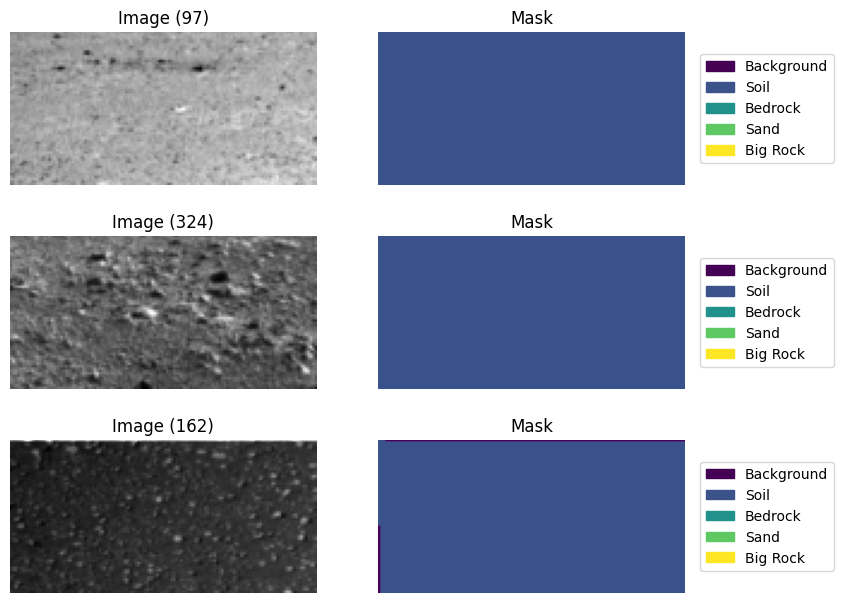

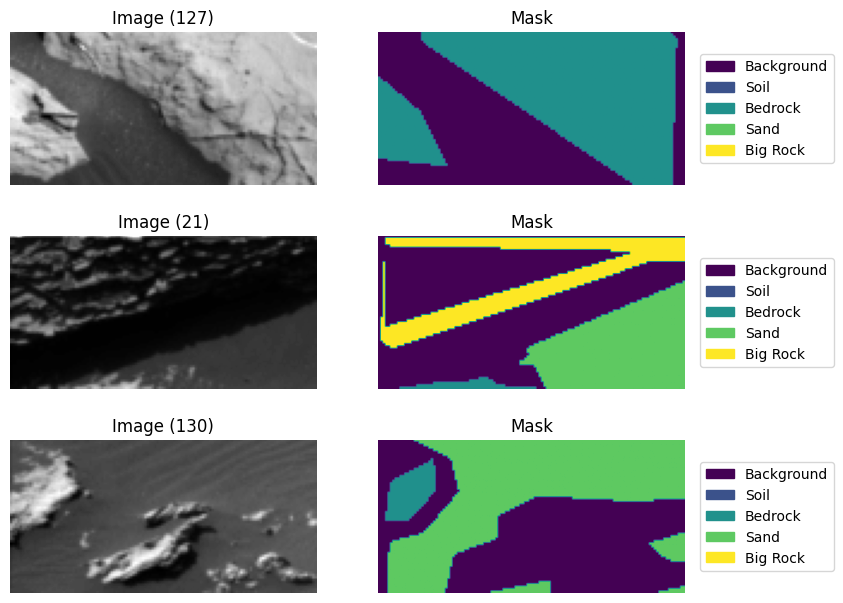

Mean 1: 0.24414454400539398
Std. dev. 1 0.10317999124526978
Mean 2: 0.22530823945999146
Std. dev. 2 0.09561222791671753
Epoch 1/200


I0000 00:00:1734109424.618942      96 service.cc:145] XLA service 0x7f813c0257a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734109424.619008      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/21 ━━━━━━━━━━━━━━━━━━━━ 18:26 55s/step - inter_output_cmean_iou: 0.0000e+00 - loss: 0.7004 - main_output_cmean_iou: 0.0421

I0000 00:00:1734109461.920105      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_reduce_fusion_23', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1734109461.951801      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - inter_output_cmean_iou: 0.0406 - loss: 0.6956 - main_output_cmean_iou: 0.0964 - val_inter_output_cmean_iou: 0.0632 - val_loss: 0.6785 - val_main_output_cmean_iou: 0.1035 - learning_rate: 0.0010
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - inter_output_cmean_iou: 0.0698 - loss: 0.6783 - main_output_cmean_iou: 0.1376 - val_inter_output_cmean_iou: 0.0782 - val_loss: 0.6768 - val_main_output_cmean_iou: 0.1045 - learning_rate: 0.0010
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - inter_output_cmean_iou: 0.1005 - loss: 0.6751 - main_output_cmean_iou: 0.1467 - val_inter_output_cmean_iou: 0.0910 - val_loss: 0.6720 - val_main_output_cmean_iou: 0.2021 - learning_rate: 0.0010
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - inter_output_cmean_iou: 0.0998 - loss: 0.6711 - main_output_cmean_iou: 0.1686 - val_inter_output_cmean_iou: 0.0910 - val_loss: 0.6644 - val_main_output_cmean_iou: 0.2358 - learning_rate: 0.0010
Epoch 5/200
21/21 

In [ ]:
def normalize_tensor(tensor, mean, stddev):
    return (tensor - mean) / (stddev + 1e-7)
    
show_random(X_val_1, y_val_1, times=3)
show_random(X_val_2, y_val_2, times=3)

input_shape = X_train.shape[1:]

# Add color channel and rescale pixels between 0 and 1
X_train_1, X_train_2 = tf.cast(X_train_1, tf.float32) / 255.0, tf.cast(X_train_2, tf.float32) / 255.0
X_val_1, X_val_2 = tf.cast(X_val_1, tf.float32) / 255.0, tf.cast(X_val_2, tf.float32) / 255.0
X_test  = tf.cast(X_test, tf.float32) / 255.0

mean_1, stddev_1 = tf.math.reduce_mean(X_train_1).numpy(), tf.math.reduce_std(X_train_1).numpy()
mean_2, stddev_2 = tf.math.reduce_mean(X_train_2).numpy(), tf.math.reduce_std(X_train_2).numpy()
X_train_1, X_train_2, X_val_1, X_val_2 = normalize_tensor(X_train_1, mean_1, stddev_1), normalize_tensor(X_train_2, mean_2, stddev_2), normalize_tensor(X_val_1, mean_1, stddev_1), normalize_tensor(X_val_2, mean_2, stddev_2)

print(f"Mean 1: {mean_1}\nStd. dev. 1 {stddev_1}")
print(f"Mean 2: {mean_2}\nStd. dev. 2 {stddev_2}")

model = build_segmentation_model(
    input_shape=input_shape,
    num_classes=num_classes
)

# Define the MeanIoU ignoring the background class

## Simple metric
#mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

## Custom metrics
inter_cmean_iou = MeanIntersectionOverUnion(
    num_classes=num_classes,
    labels_to_exclude=[0],
    class_weights=class_weights
)
main_cmean_iou = MeanIntersectionOverUnion(
    num_classes=num_classes,
    labels_to_exclude=[0],
    class_weights=class_weights
)

outputs = ["inter_output", "main_output"]

model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate),
    metrics={
        "inter_output" : [inter_cmean_iou],
        "main_output"  : [main_cmean_iou]
    },
    loss={
        "inter_output" : inter_loss,
        "main_output"  : main_loss
    },
    loss_weights={
        "inter_output" : 0.3,
        "main_output"  : 0.7
    }
)

# Setup callbacks
## Early stopping
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_main_output_cmean_iou",
    mode='max',
    patience=patience,
    restore_best_weights=True,
    start_from_epoch = patience if epochs > patience else 0
)

## Learning rate schedule
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_main_output_cmean_iou",
    factor=0.5,
    mode="max",
    patience=10,
    min_lr=learning_rate / 100
)

#model.summary()

history = model.fit(
    data_pipeline(X_train_1, y_train_1, X_train_2, y_train_2, augment_fn=augment_image if augmentation else None),
    steps_per_epoch = max(len(y_train_1), len(y_train_2)) // batch_size,
    epochs=epochs,
    batch_size=batch_size,
    validation_steps=max(len(y_val_1), len(y_val_2)) // batch_size,
    validation_data=data_pipeline(X_val_1, y_val_1, X_val_2, y_val_2),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
).history

# Plot the metrics

In [ ]:
print(history.keys())
# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['inter_output_cmean_iou'], label='Inter MIoU', alpha=.8)
plt.plot(history['val_inter_output_cmean_iou'], label='Inter validation MIoU', alpha=.8)
plt.plot(history['main_output_cmean_iou'], label='MIoU', alpha=.8)
plt.plot(history['val_main_output_cmean_iou'], label='Main validation MIoU', alpha=.8)
plt.title('MIoUs')
plt.legend()
plt.grid(alpha=.3)

plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

"""
plt.figure(figsize=(15, 2))
plt.plot(history['low_loss'], label='low_loss', alpha=.8)
plt.plot(history['inter_loss'], label='inter_loss', alpha=.8)
plt.plot(history['main_loss'], label='main_loss', alpha=.8)
plt.title('Losses')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(history['val_low_loss'], label='val_low_loss', alpha=.8)
plt.plot(history['val_inter_loss'], label='val_inter_loss', alpha=.8)
plt.plot(history['val_main_loss'], label='val_main_loss', alpha=.8)
plt.title('Validation losses')
plt.legend()
plt.grid(alpha=.3)
plt.show()
"""

# Testing process

In [ ]:
X_test = normalize_tensor(X_test, mean_2, stddev_2)
y_pred = model.predict([X_test, X_test])
y_pred = np.argmax(y_pred, axis=-1)
y_true = y_train

max_val = max(len(X_val_1), len(X_val_2))
X_val_1_red, X_val_2_red = tf.gather(X_val_1, indices=tf.range(max_val)), tf.gather(X_val_2, indices=tf.range(max_val))

y_pred_val = model.predict([X_val_1_red, X_val_2_red])
y_pred_val = np.argmax(y_pred_val, axis=-1)

In [ ]:
mean_iou_metric = tfk.metrics.MeanIoU(num_classes=num_classes)

# Flatten per calcolare la matrice di confusione
y_true_val_flat = y_true_val.numpy()[:max_val].flatten()
y_pred_val_flat = y_pred_val[-1].flatten()

# Calcola la matrice di confusione
conf_matrix = tf.math.confusion_matrix(y_true_val_flat, y_pred_val_flat, num_classes=num_classes).numpy()

# Calcola la IoU per ogni classe
ious_per_class = []
for i in range(1, num_classes):
    tp = conf_matrix[i, i]  # True positives
    fp = np.sum(conf_matrix[:, i]) - tp  # False positives
    fn = np.sum(conf_matrix[i, :]) - tp  # False negatives
    denom = tp + fp + fn
    iou = tp / denom if denom != 0 else 0
    ious_per_class.append(iou)

# Stampa la IoU per ciascuna classe
for class_id, iou in enumerate(ious_per_class, start=1):
    print(f"{labels[class_id]} -> IoU = {iou:.4f}")

# Stampa la mIoU
miou = np.mean(ious_per_class)
print(f"Mean IoU = {miou:.4f}")

classes = [labels[i] for i in range(1, num_classes)]
plt.bar(classes, ious_per_class)
plt.xlabel("Classes")
plt.ylabel("IoU")
plt.title("IoU per class")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)
plt.show()

In [ ]:
def visualize_val_predictions(X, y_true, y_pred, index, class_labels):
    # Generate figure
    plt.figure(figsize=(8 * len(y_pred), 4))
    
    # Original image
    plt.subplot(1, 2 + len(y_pred), 1)
    plt.title(f"Val image ({index})")
    plt.imshow(np.array(X[index]).squeeze(), cmap="gray")
    plt.axis("off")
    
    # Predicted masks
    for i, output in enumerate(y_pred) :
        plt.subplot(1, 2 + len(y_pred), 2 + i)
        plt.title(f"{outputs[i]}'s mask")
        plt.imshow(output[index], cmap="viridis", vmin=0, vmax=len(labels) - 1)
        plt.axis("off")
    
    # True mask
    plt.subplot(1, 2 + len(y_pred), 2 + len(y_pred))
    plt.title("True mask")
    plt.imshow(y_true[index], cmap="viridis", vmin=0, vmax=len(labels) - 1)
    plt.axis("off")
    
    # Add a legend outside the plot
    plt.subplots_adjust(right=0.8)  # Leave space for the legend
    cmap = plt.cm.viridis  # Use the same colormap
    colors = [cmap(i / (len(class_labels)-1)) for i in range(len(class_labels))]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, class_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
    
    plt.show()

for i in range(30):
    visualize_val_predictions(X_val, y_true_val, y_pred_val, np.random.randint(0, y_pred_val.shape[-3]), labels.values())

# Save the model

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

# Prepare the submission

In [ ]:
"""from tensorflow.keras.metrics import MeanIoU

custom_objects = {
    'MeanIntersectionOverUnion': MeanIntersectionOverUnion,
    'loss_fn' : combined_loss_wrapper(weights_list, c_dice, c_focal, c_boundary, c_weights) if balance_mode == "weights" or balance_mode == "mixed" else None,
}

model = tfk.models.load_model(model_filename, custom_objects=custom_objects)"""

preds = y_pred[-1]
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"The file {submission_filename} has been saved. You can download it in the 'Output' section on Kaggle.")